# How to train an ontology-based variational autoencoder (Ontix)

In normal autoencoders, latent dimensions are not explainable by design. To gain explainability and incorporate biological information, a popular approach is to restrict the decoder of the autoencoder to match feature connectivity, such as an ontology. 

**IMPORTANT**

> This tutorial only shows the specifics of the Ontix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` Tutorial first.

## What You'll Learn

In this notebook we will show two types of ontologies and how they can be used to train an explainable variational autoencoder, `Ontix`. 
The first is based on biological pathways from the Reactome database (left), and the second uses chromosomal location of genes (right) as a showcase. 

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/5dabc4a697cbba74d3f6144dc4b6d0fd6df2b624/images/ontix_scheme.svg" alt="ontix-ontologies" width="1200"/>

You’ll learn how to:

1. **Initialize** the pipeline, ontologies, and run Ontix with **chromosomal ontologies**. <br><br>
2. **Initialize** the pipeline, ontologies, and run Ontix with **Reactome pathways**. <br><br>
3. **Evaluate** Ontix on downstream tasks. <br><br>

By working with these examples, we will also cover on the go:  <br><br>
- Understand the Ontix-specific **pipeline steps**. <br><br>
- Access the Ontix-specific **results** (mu, sigma, KL/MMD losses). <br><br>
- **Visualize** outputs effectively. <br><br>
- Apply **custom parameters**. <br><br>
- **Save, load, and reuse** a trained pipeline. <br><br>


## 1) Set-up Ontology and Initialize Pipeline with Chromosomal Ontology

The only thing you need to do to train an `Ontix` model is to provide information about your ontologies. You can do this via `.txt` files or directly as Python dictionaries. In this example, we use text files. We plan to extend this tutorial in the future with an example using Python dictionaries (TODO JE).

You can provide up to `n` ontology files and pass them as a list to the `Ontix` pipeline object. The list should be ordered so that the last ontology level corresponds to the mapping of your features (e.g., Gene ID) to an ontology level like subpathways or cytobands of chromosomes. More levels are optional but recommended, as they map gene names to higher-level categories like top-level pathways or chromosome regions.



The mapping of the last level should have the format:  
Gene 1 `separator` Pathway1  
Gene 2 `separator` Pathway1  
Gene 3 `separator` Pathway2  <br><br>

#### 1.1 Prepare Ontology Data
We quickly show how to prepare a downloaded ontology into a text file that serves as input for `Ontix`.  

**Example 1: Set-up chromosomal ontology**:  

From Ensembl via Biomart or any other sequence database, you can get cytoband (karyotype) and chromosomal information for human genes like this:


In [1]:
import pandas as pd

# Download from https://github.com/jan-forest/autoencodix/blob/main/Tutorials/genes_chromosomes.txt
df_genes = pd.read_csv("genes_chromosomes.txt", sep="\t")
df_genes.head()

,Gene stable ID,Gene stable ID version,Karyotype band,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HGNC symbol,NCBI gene (formerly Entrezgene) ID
0,ENSG00000198888,ENSG00000198888.2,NaN,MT,3307,4262,MT-ND1,4535
1,ENSG00000198763,ENSG00000198763.3,NaN,MT,4470,5511,MT-ND2,4536
2,ENSG00000198804,ENSG00000198804.2,NaN,MT,5904,7445,MT-CO1,4512
3,ENSG00000210151,ENSG00000210151.2,NaN,MT,7446,7514,MT-TS1,113219467
4,ENSG00000198712,ENSG00000198712.1,NaN,MT,7586,8269,MT-CO2,4513


We have to solve some issues before we can use this as ontology.  
(1) We only want chromosomes and not scaffolds  
(2) Karyotype/cytoband should have identification of the chromosome in their name as identifier

In [2]:
df_genes = df_genes.loc[
    df_genes["Chromosome/scaffold name"].str.len() < 3
]  ## get rid of scaffolds and keep only chromosomes
df_genes.loc[df_genes["Chromosome/scaffold name"] == "MT", "Karyotype band"] = (
    "MT"  ## create missing karyotype for mito genes
)
print("This will be our chromosomes and latent dimensions in Ontix:")
print(df_genes["Chromosome/scaffold name"].unique())
print(f"Latent dimension: {len(df_genes['Chromosome/scaffold name'].unique())}")

This will be our chromosomes and latent dimensions in Ontix:
['MT' 'Y' '21' '13' '18' '22' '20' 'X' '15' '14' '10' '9' '8' '16' '4' '5'
 '7' '6' '19' '12' '11' '3' '17' '2' '1']
Latent dimension: 25


In [3]:
# Combine Chromosome name and cytoband
df_genes = df_genes.copy()
df_genes.loc[:, "Chr_and_karyotype"] = df_genes.loc[
    :, ["Chromosome/scaffold name", "Karyotype band"]
].apply(lambda x: ":".join(x.values.tolist()), axis=1)
print("This will be our hidden layer in the sparse decoder:")
print(df_genes["Chr_and_karyotype"].unique()[0:20])
print(f"Hidden layer dim: {len(df_genes['Chr_and_karyotype'].unique())}")

This will be our hidden layer in the sparse decoder:
['MT:MT' 'Y:p11.2' 'Y:q11.223' 'Y:q11.221' 'Y:q11.222' 'Y:q11.23'
 'Y:p11.31' 'Y:p11.32' 'Y:q12' '21:p12' '21:q21.1' '21:q21.2' '21:p11.2'
 '13:q12.12' '21:q21.3' '21:q22.11' '13:q12.3' '13:q14.12' '13:q14.2'
 '21:q22.12']
Hidden layer dim: 817


Now we can save this as files in the correct format for the two levels:

In [4]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")
# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"
ont_genelevel = "chromosome_ont_genelevel_ncbi.txt"
ont_hiddenlevel = "chromosome_ont_hiddenlevel.txt"

# FEATURE TO TO ONTOLOGY LEVEL
df_genes[
    [
        "NCBI gene (formerly Entrezgene) ID",
        "Chr_and_karyotype",
    ]  # Level Feature: Feature (gene) to hidden layer (cytoband)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_genelevel),
    sep="\t",
    header=False,
    index=False,
)

# ONTOLOGY TO LATENT DIMENSION LEVEL
df_genes[
    [
        "Chr_and_karyotype",
        "Chromosome/scaffold name",
    ]  # Level Hidden: hidden layer (cytoband) to latent dimension (chromosome)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_hiddenlevel),
    sep="\t",
    header=False,
    index=False,
)

Changed to: /home/ewald/Github/autoencodix_package


#### 1.2 Create Your Config and Run Pipeline
The initialization of the config does not work differently as for other pipelines, but with the constraint that we only allow `MINMAX` scaling as scaling method. The `ontix` pipeline itself takes an additional `ontologies` keyword argument. Here you pass either the list of ontology files (with the pathway-to-gene-id mapping as last entry).

In [5]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import OntixConfig

# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"

# ---------------------------------------------------------------------
# Define individual data modalities
# ---------------------------------------------------------------------
rna_info = DataInfo(
    file_path=os.path.join(data_root, rna_file),
    data_type="NUMERIC",
    filtering="VAR",
)

meth_info = DataInfo(
    file_path=os.path.join(data_root, meth_file),
    data_type="NUMERIC",
    filtering="VAR",
)

anno_info = DataInfo(
    file_path=os.path.join(data_root, clin_file),
    data_type="ANNOTATION",
)

# ---------------------------------------------------------------------
# Combine into DataConfig
# ---------------------------------------------------------------------
data_config = DataConfig(
    data_info={
        "RNA": rna_info,
        "METH": meth_info,
        "ANNO": anno_info,
    },
    annotation_columns=[
        "CANCER_TYPE",
        "CANCER_TYPE_ACRONYM",
        "TMB_NONSYNONYMOUS",
        "AGE",
        "OS_STATUS",
        "GRADE",
        "SEX",
    ],
)

# ---------------------------------------------------------------------
# Define the full DefaultConfig (roughly equivalent to old cfg)
# ---------------------------------------------------------------------
ontix_config = OntixConfig(
    data_config=data_config,
    reproducible=True,
    global_seed=42,
    epochs=5,
    learning_rate=0.0005,
    batch_size=128,
    drop_p=0.3,
    k_filter=1000,
    latent_dim=6,
    reconstruction_loss="mse",
    default_vae_loss="kl",
    beta=0.5,
    save_memory=False,
    scaling="MINMAX",
    device="auto",
    train_ratio=0.7,
    test_ratio=0.2,
    valid_ratio=0.1,
)

# ---------------------------------------------------------------------
# Now pass into your Ontix object
# ---------------------------------------------------------------------

ont_files = [ont_hiddenlevel, ont_genelevel]
ont_files = [os.path.join(data_root, f) for f in ont_files]
ontix = acx.Ontix(
    ontologies=ont_files,
    config=ontix_config,
)


In [6]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [7]:
r = ontix.run()

reading parquet: data/raw/combined_rnaseq_formatted.parquet
reading parquet: data/raw/combined_meth_formatted.parquet
reading parquet: data/raw/combined_clin_formatted.parquet
anno key: paired
Features in feature_order not found in all_feature_names: ['100133144', '10357', '10431', '155060', '390284', '57714', '645851', '653553', '729884', '246182', '119385', '653268', '728404', '200810', '138649', '441425', '728747', '729171', '23520', '303', '304', '305', '244', '375719', '441432', '503640', '641522', '432369', '92270', '6791', '85319', '606', '23629', '286076', '414235', '170393', '255352', '283422', '283416', '374467', '84837', '400223', '650662', '280655', '283651', '80035', '283687', '196968', '284185', '147429', '147525', '494514', '574036', '284573', '149469', '84791', '253868', '284836', '54094', '54067', '282566', '114041', '114043', '149992', '55267', '29798', '348738', '339942', '93556', '646450', '317648', '92070', '79614', '153571', '116349', '441108', '285679', '85411', 

### Gaining insights by explainable latent dimensions and visualizations
The idea behind using the chromosomal location of features (genes) as an ontology for `Ontix` is that we can expect male and female patients to be separated along the `Y` and `X` chromosomes.  
Let’s check if this is indeed the case:


Creating plots ...


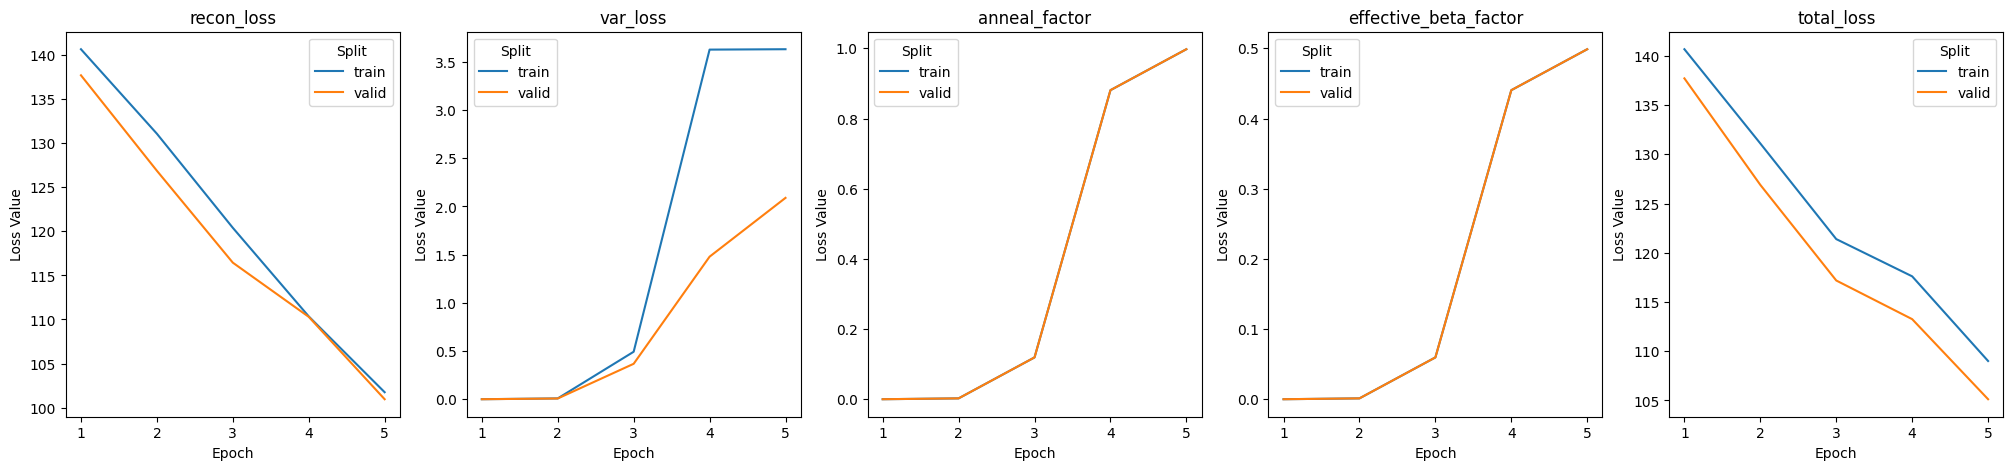

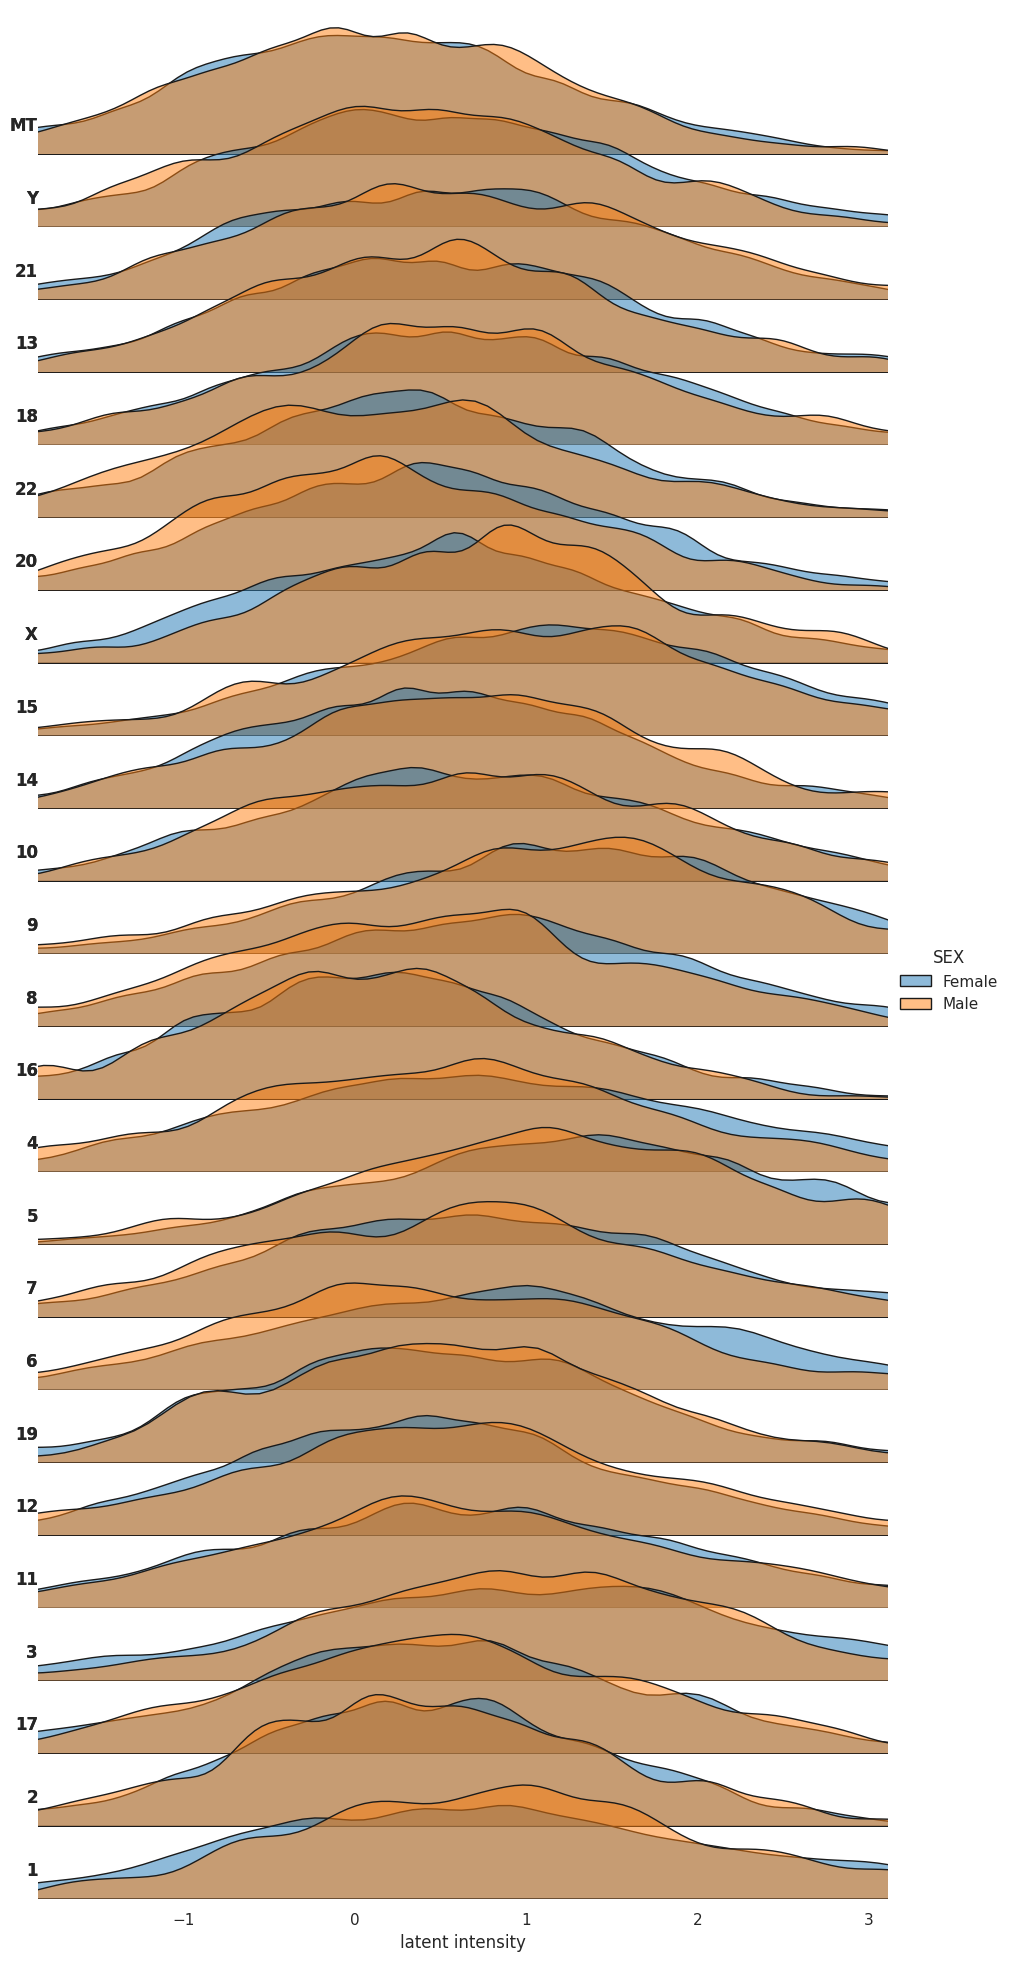

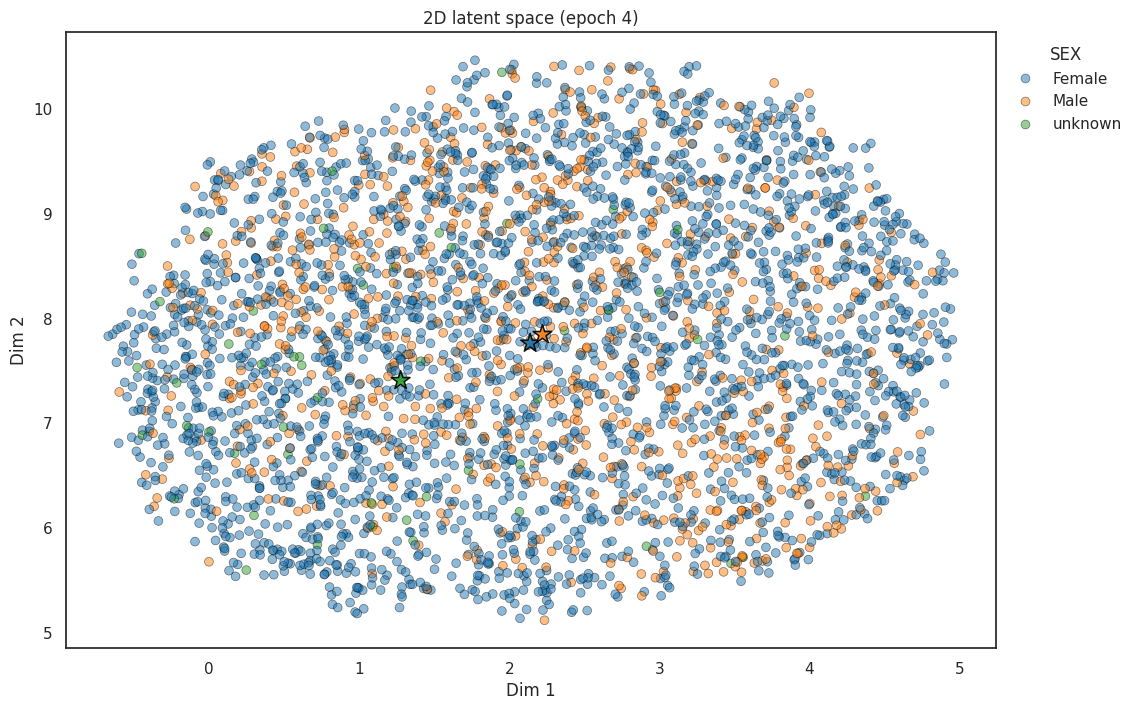

In [8]:
ontix.show_result(params=["SEX"])

In [11]:
ontix.result.get_latent_df(epoch=4, split="train")

,MT,Y,21,13,18,22,20,X,15,14,...,5,7,6,19,12,11,3,17,2,1
TCGA-04-1362-01,0.417990,0.523614,1.325246,0.200782,0.375166,-0.883078,2.205968,-1.660681,2.719554,-0.168905,...,1.427907,-1.745693,2.257883,1.444565,-1.097771,-1.458333,-1.645043,-1.235816,0.424316,-0.988682
TCGA-04-1364-01,-1.502513,-1.646776,1.744714,-1.368399,-1.401968,0.093469,-0.226598,-0.398895,1.964543,0.757681,...,-0.292628,-1.022023,0.341073,0.119279,0.662878,0.164527,1.056905,0.132967,0.021859,-0.194233
TCGA-04-1365-01,-1.982706,0.035760,1.205784,0.199172,0.588816,-0.465179,0.340991,0.192523,-0.357225,-0.582990,...,0.773150,-0.083652,-1.043991,0.147052,0.959914,0.718964,-0.882583,-0.119887,-1.066431,1.053705
TCGA-04-1514-01,-0.914520,1.820561,1.083720,0.251350,0.121193,-0.820855,-0.898499,0.679468,1.675385,-0.832368,...,0.182287,0.449054,0.079396,0.445187,-0.698026,-1.001055,-0.223672,0.458049,-0.898669,-0.438410
TCGA-04-1519-01,-2.306045,0.393474,-0.709748,-0.081871,0.865981,1.077729,1.046889,1.870467,1.874573,-0.112885,...,0.364127,1.025136,2.323208,-0.147094,0.305835,1.490326,-2.429565,0.390310,2.314242,-0.713898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB41-01,1.679040,-0.281087,-0.446607,-0.930225,1.465949,0.201901,0.466947,-1.563689,-0.229088,1.751151,...,3.286852,2.774045,1.242221,3.058709,0.874770,-0.251331,2.100657,3.655924,0.880437,2.578486
TCGA-XX-A899-01,2.336270,2.118631,1.609656,0.115764,0.757597,2.103717,2.364219,-0.400362,0.631774,-0.399644,...,-0.551486,1.928659,0.983693,0.843157,-0.743101,-0.192090,2.442355,1.942461,1.367969,0.840942
TCGA-XX-A89A-01,0.975924,1.400320,1.024602,0.998790,0.218278,0.587556,0.121857,0.664057,1.744889,1.762766,...,1.092356,-0.010825,2.436330,1.378845,0.684840,0.994679,-1.334072,1.985535,-0.494947,-2.232979
TCGA-Z7-A8R5-01,1.192693,1.018252,1.400922,1.952390,2.162923,1.674016,-1.401130,-0.707976,-2.049178,0.005812,...,0.079044,0.569855,0.832815,1.595787,0.937509,0.025517,1.242931,0.836488,-1.515394,4.840368


In [13]:
ontix.evaluate(
	params=["SEX"]
)

Perform ML task with feature df: Latent
                   PATIENT_ID ONCOTREE_CODE               CANCER_TYPE  \
SAMPLE_ID                                                               
TCGA-04-1362-01  TCGA-04-1362           SOC  Ovarian Epithelial Tumor   
TCGA-04-1364-01  TCGA-04-1364           SOC  Ovarian Epithelial Tumor   
TCGA-04-1365-01  TCGA-04-1365           SOC  Ovarian Epithelial Tumor   
TCGA-04-1514-01  TCGA-04-1514           SOC  Ovarian Epithelial Tumor   
TCGA-04-1519-01  TCGA-04-1519           SOC  Ovarian Epithelial Tumor   
...                       ...           ...                       ...   
TCGA-S3-AA14-01  TCGA-S3-AA14           IDC             Breast Cancer   
TCGA-SJ-A6ZI-01  TCGA-SJ-A6ZI           UEC        Endometrial Cancer   
TCGA-SL-A6J9-01  TCGA-SL-A6J9           UEC        Endometrial Cancer   
TCGA-SS-A7HO-01  TCGA-SS-A7HO          COAD         Colorectal Cancer   
TCGA-UL-AAZ6-01  TCGA-UL-AAZ6           IDC             Breast Cancer   

          

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7d348b4197e0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7d348b41b040>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7d348b307520>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 707 × 25
    uns: 'var_names'
final_reconstru

## 2) Set-up Ontology and Initialize Pipeline with Reactome Pathways
Chromosomal location as ontology is mostly a proof of concept as shown above how to gain explainability of latent dimensions.  
In practice, something like biological pathways or gene ontology is most commonly used to gain biological insights. 

In [ ]:
reactome_genelevel = "full_ont_lvl1_reactome.txt"
reactome_hiddenlevel = "full_ont_lvl2_reactome_named.txt"
ont_files = [reactome_hiddenlevel, reactome_genelevel]
ont_files = [os.path.join(data_root, f) for f in ont_files]
ontix_react = acx.Ontix(ontologies=ont_files, config=ontix_config)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/full_ont_lvl2_reactome_named.txt'

In [ ]:
result = ontix_react.run()

reading parquet: data/raw/combined_rnaseq_formatted.parquet
reading parquet: data/raw/combined_meth_formatted.parquet
reading parquet: data/raw/combined_clin_formatted.parquet
anno key: paired
Features in feature_order not found in all_feature_names: ['100133144', '100134869', '10357', '10431', '155060', '388795', '390284', '57714', '645851', '653553', '729884', '8225', '90288', '87769', '144568', '729522', '79719', '80755', '132949', '9625', '79963', '650655', '150000', '653190', '730013', '55324', '83451', '145447', '84945', '25864', '116236', '84696', '11057', '79575', '51225', '25890', '29777', '80325', '25841', '9744', '23527', '116983', '84680', '57001', '52', '53', '92370', '84519', '93953', '56', '81569', '57180', '653857', '64431', '90', '97', '98', '161931', '10863', '203102', '8755', '27299', '55803', '105', '57143', '90956', '79934', '203054', '22850', '23394', '141', '113622', '165', '64782', '60312', '134265', '84632', '246182', '4299', '2334', '3899', '172', '54812', '38

#### Gaining Insights by Visualizing Latent Dimensions
In comparison to other pipelines, `Ontix` has interpretable latent dimensions as shown in the plots below:


Creating plots ...


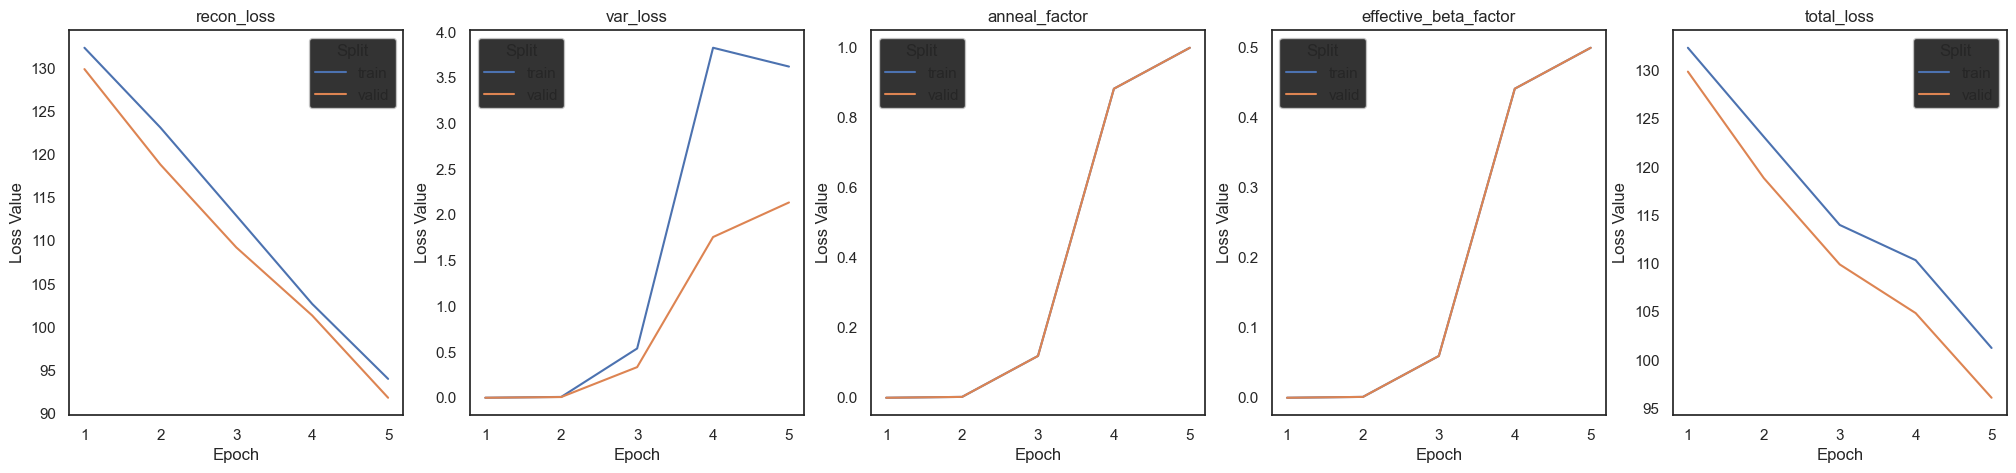

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 29)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 29)
  warnings.warn(


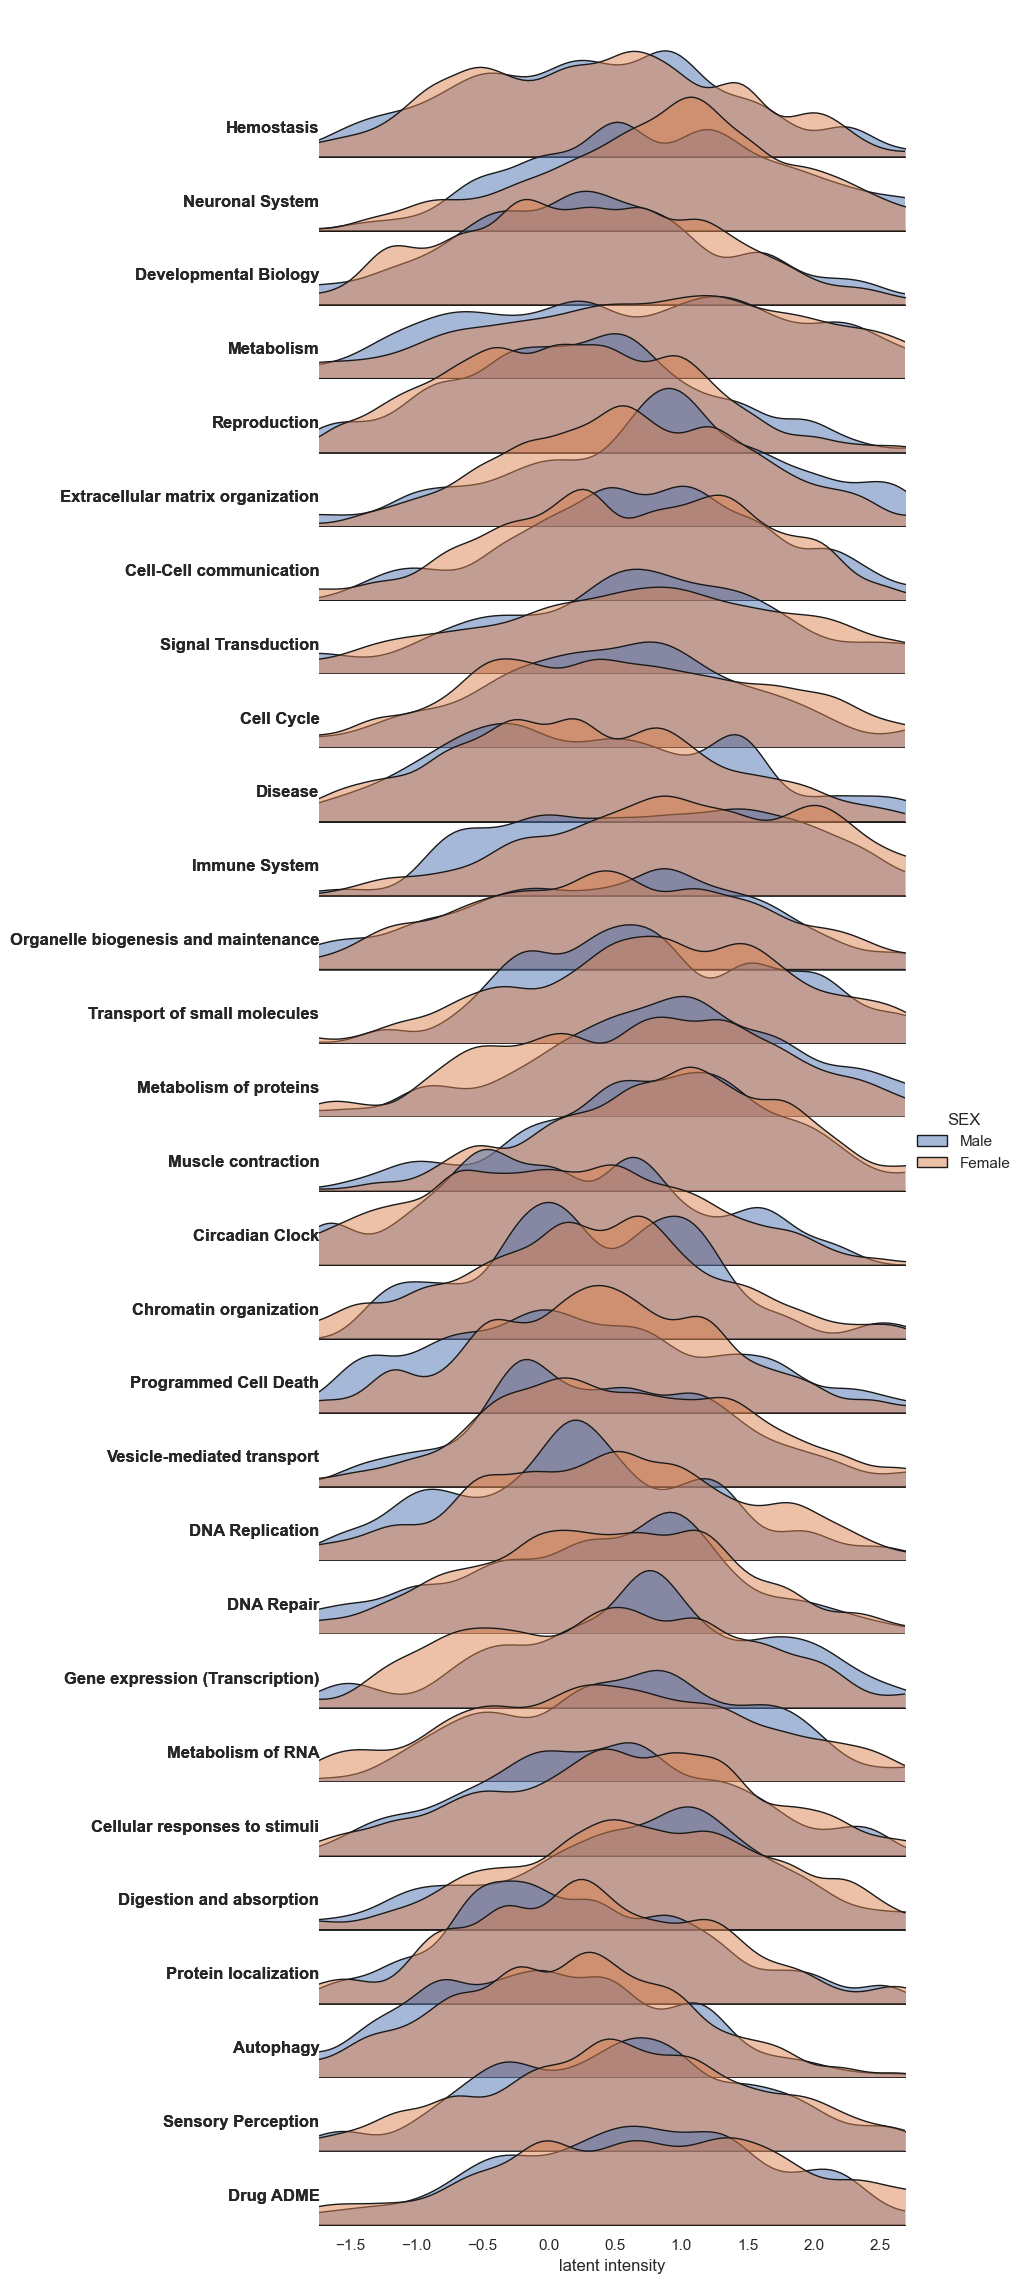

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 29)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 29)
  warnings.warn(


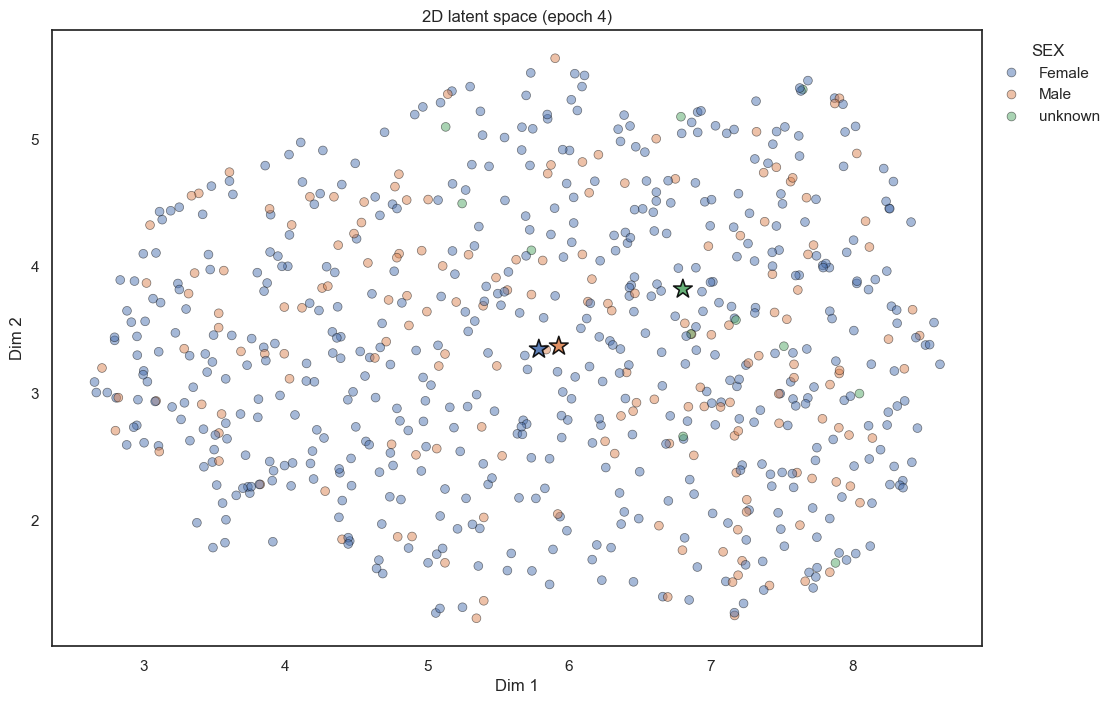

In [ ]:
ontix_react.show_result(params=["SEX"])

#### Obtain Results
If we're interested in working with latent spaces, reconstructions, or losses, we can access these for `Ontix` as for any other pipeline. For more details see `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`.


In [ ]:
print(f"The following results are saved: {list(r.__dict__.keys())}")
train_loss = r.losses.get(split="train", epoch=20)

print(f"Loss at epoch 20 for split train was: {train_loss}")
ls = r.latentspaces.get(split="test", epoch=-1)
ls


The following results are saved: ['latentspaces', 'sample_ids', 'reconstructions', 'mus', 'sigmas', 'losses', 'sub_losses', 'preprocessed_data', 'model', 'model_checkpoints', 'datasets', 'new_datasets', 'adata_latent', 'final_reconstruction', 'sub_results', 'sub_reconstructions', 'embedding_evaluation']
Loss at epoch 20 for split train was: []


array([[ 0.9092125 ,  0.336798  ,  0.23764823, ...,  1.6564418 ,
         0.206833  , -1.4254009 ],
       [ 0.79641265,  1.0892545 ,  1.326234  , ...,  1.2974366 ,
         0.00786451,  0.9612803 ],
       [ 0.24602954, -1.2620566 ,  0.8468425 , ...,  0.48354718,
         0.7453292 , -0.377247  ],
       ...,
       [-0.31901315,  1.4406576 ,  0.07766122, ...,  1.3906482 ,
         0.37146556,  0.9901087 ],
       [-1.7732768 , -0.39864367,  1.8951683 , ..., -0.82244295,
         1.8256645 ,  0.8637211 ],
       [ 0.5235707 ,  1.6022246 , -0.11716501, ...,  1.582873  ,
         0.08181417,  2.555952  ]], shape=(707, 25), dtype=float32)

#### Save Ontix
Like all other pipelines we can save, load and re-use `Ontix` as shown below:

In [ ]:

import os
import glob

outpath = os.path.join("tutorial_res", "ontix.pkl")
ontix.save(file_path=outpath, save_all=True)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
ontix_loaded = acx.Ontix.load(outpath)

Preprocessor saved successfully.
saving memory efficient
Ontix checks:
All possible feature names length: 27248
Feature order length: 1000
Feature names without filtering: 1000
Mask layer 0 with shape torch.Size([817, 25]) and 817.0 connections
Mask layer 1 with shape torch.Size([1000, 817]) and 991.0 connections
Latent Dim: 25
Pipeline object saved successfully.
PKL files: ['tutorial_res/ontix.pkl', 'tutorial_res/varix.pkl_preprocessor.pkl', 'tutorial_res/varix.pkl', 'tutorial_res/xmodalix.pkl', 'tutorial_res/xmodalix.pkl.pkl', 'tutorial_res/varix.pkl.pkl', 'tutorial_res/ontix_reactome.pkl.pkl', 'tutorial_res/ontix_reactome.pkl_preprocessor.pkl', 'tutorial_res/xmodalix.pkl_preprocessor.pkl']
Model files: ['tutorial_res/ontix_reactome.pkl_model.pth', 'tutorial_res/xmodalix.pkl_model.pth', 'tutorial_res/varix.pkl_model.pth']
Attempting to load a pipeline from tutorial_res/ontix.pkl.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.


In [ ]:
ontix_loaded.show_result()

Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


IndexError: list index out of range

In [ ]:

test = ontix_react.result.datasets.test
ontix_react.save(file_path=os.path.join("tutorial_res", "ontix_reactome.pkl"))
ontix_react_loaded = acx.Ontix.load(os.path.join("tutorial_res", "ontix_reactome.pkl"))

Preprocessor saved successfully.
saving memory efficient
Ontix checks:
All possible feature names length: 11308
Feature order length: 1000
Feature names without filtering: 1000
Mask layer 0 with shape torch.Size([638, 29]) and 641.0 connections
Mask layer 1 with shape torch.Size([1000, 638]) and 6783.0 connections
Latent Dim: 29
Pipeline object saved successfully.
Attempting to load a pipeline from tutorial_res/ontix_reactome.pkl.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.


## 3) Evaluate Ontix on Downstream Tasks
TODO JE